In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
#import cv2
import tensorflow as tf
#import tensorflow.keras.layers as L
from PIL import Image, ImageFile

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

In [3]:
folder = '../input/cbir-dataset/dataset/'
photo = [folder+x for x in os.listdir(folder)]
photos = pd.DataFrame()
photos['dir'] = photo

In [4]:
photos

,dir
0,../input/cbir-dataset/dataset/1269.jpg
1,../input/cbir-dataset/dataset/3863.jpg
2,../input/cbir-dataset/dataset/623.jpg
3,../input/cbir-dataset/dataset/2193.jpg
4,../input/cbir-dataset/dataset/3750.jpg
...,...
4733,../input/cbir-dataset/dataset/3950.jpg
4734,../input/cbir-dataset/dataset/728.jpg
4735,../input/cbir-dataset/dataset/1656.jpg
4736,../input/cbir-dataset/dataset/3361.jpg


In [5]:
import pickle
# store features in pickle
pickle.dump(photo, open(os.path.join('./', 'images_dir.pkl'), 'wb'))

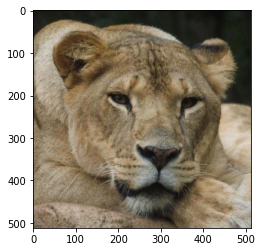

In [6]:
def display(path_img):
    plt.imshow(plt.imread(path_img))
    plt.show()
display(photos['dir'][48])

In [7]:
img_arr=[]
for file in photos['dir']:
    img = Image.open(file)
    img = np.array(img.resize((224, 224)))
    img_arr.append(img)


In [8]:
img_arr = np.array(img_arr)/255.0
img_arr.shape

(4738, 224, 224, 3)

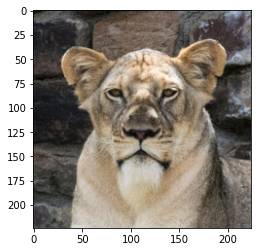

In [9]:
plt.imshow(img_arr[1])
plt.show()

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

2022-05-31 07:10:02.538344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:10:02.627226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:10:02.627965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 07:10:02.629658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
fine_tune_at = 148

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.20)(x)
outputs = tf.keras.layers.Dense(1280, activation='relu')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1280)              1639680   
Total params: 3,897,664
Trainable params: 1,639,680
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
# extract features from database image
feature = model.predict(img_arr, verbose=1)

2022-05-31 07:10:07.952065: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2852806656 exceeds 10% of free system memory.
2022-05-31 07:10:11.014165: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2852806656 exceeds 10% of free system memory.
2022-05-31 07:10:13.139828: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-31 07:10:14.911112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


149/149 [==============================] - 11s 25ms/step


In [14]:
model.save('model1.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
import pickle
# store features in pickle
pickle.dump(feature, open(os.path.join('./', 'features1.pkl'), 'wb'))

In [16]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [17]:
#compute euclidean distances for query images and database image
def perform_search(queryFeatures, index, maxResults=64):
    results = []
    
    for i in range(0, len(index)):
        d = euclidean(queryFeatures, index[i])
        results.append((d, i))
        
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

In [18]:
# extract features of query image
index = 90
query = img_arr[index].reshape((1,224,224,3))
query = model.predict(query)

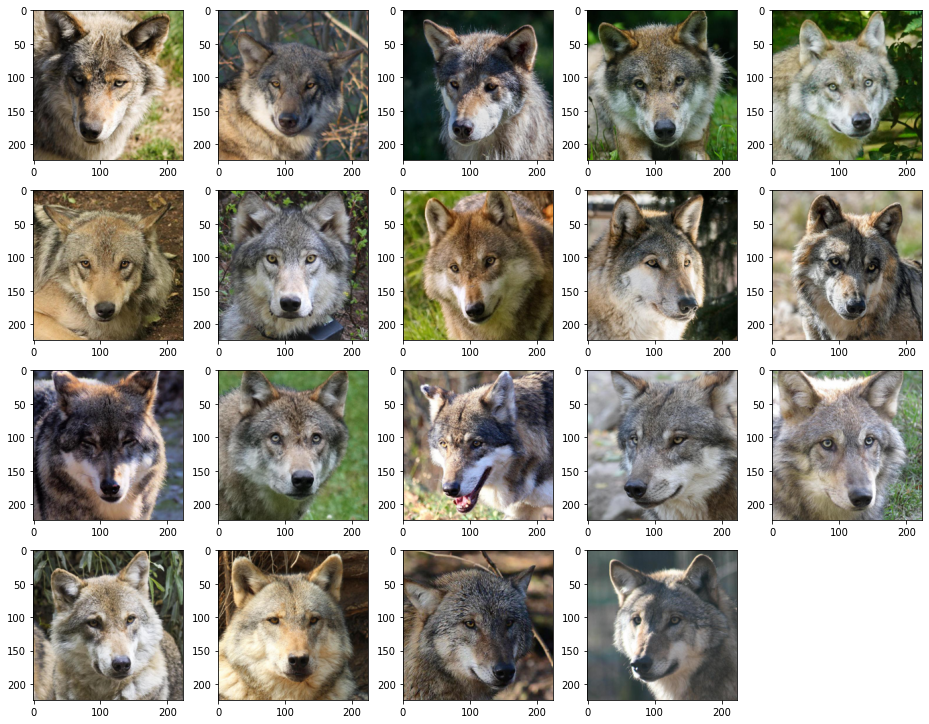

In [19]:
result = perform_search(query, feature, 20)
arr = []
for a, b in result:
    arr.append(b)
fig = plt.figure(figsize=(16, 16))
for i in range(1,20):
    #img = plt.imread(photo[arr[i-1]])
    fig.add_subplot(5, 5, i)
    plt.imshow(img_arr[arr[i-1]])
plt.show()